In [1]:
import pathlib
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# set ranking
pathway_metadata_path = pathlib.Path(
    "../0.download-data/data/sc-profiles/cfret-screen/pathways.csv"
).resolve(strict=True)
ranking_paths = pathlib.Path(
    "./results/cfret-screen/cfret_screen_treatment_rankings.csv"
).resolve(strict=True)

In [3]:
# loading in metadata infromation and profiles
pathways_df = pl.read_csv(pathway_metadata_path)
ranks_df = pl.read_csv(ranking_paths)

ranks_df

treatment,compound_score,rank,Pathway,Pathway_right
str,f64,i64,str,str
"""UCD-0159283""",2758.894675,1,"""Endocrinology & Hormones""","""Endocrinology & Hormones"""
"""UCD-0159257""",2804.479972,2,"""DNA Damage""","""DNA Damage"""
"""UCD-0159285""",2830.19691,3,"""DNA Damage""","""DNA Damage"""
"""UCD-0001016""",2847.128491,4,"""Neuronal Signaling""","""Neuronal Signaling"""
"""UCD-0017999""",2867.039419,5,"""Endocrinology & Hormones""","""Endocrinology & Hormones"""
…,…,…,…,…
"""UCD-0159286""",3570.156922,41,"""Others""","""Others"""
"""UCD-0159262""",3902.512488,42,"""Others""","""Others"""
"""UCD-0018179""",3928.919034,43,"""MAPK""","""MAPK"""


In [4]:
pathways_df = pathways_df.select(["treatment", "Pathway"])
pathways_df

treatment,Pathway
str,str
"""DMSO""",null
"""UCD-0159256""","""Apoptosis"""
"""UCD-0001766""","""Angiogenesis"""
"""DMSO""",null
"""UCD-0159262""","""Others"""
…,…
"""UCD-0018131""","""Angiogenesis"""
"""UCD-0001024""","""Neuronal Signaling"""
"""UCD-0001829""","""PI3K/Akt/mTOR"""


In [11]:
# Drop all duplicate rows
ranks_df = ranks_df.unique()

# Drop duplicates based on specific column(s)
ranks_df = ranks_df.unique(subset=["treatment", "Pathway"])

# Drop duplicates and keep original order
ranks_df = ranks_df.unique(maintain_order=True)

# Check for duplicates first
n_duplicates = ranks_df.height - ranks_df.unique().height
print(f"Number of duplicate rows: {n_duplicates}")

Number of duplicate rows: 0


/tmp/ipykernel_891712/281314739.py:13: UserWarning: Comparisons with None always result in null. Consider using `.is_null()` or `.is_not_null()`.
  pathway_data = ranks_df.filter(pl.col("Pathway") == pathway)


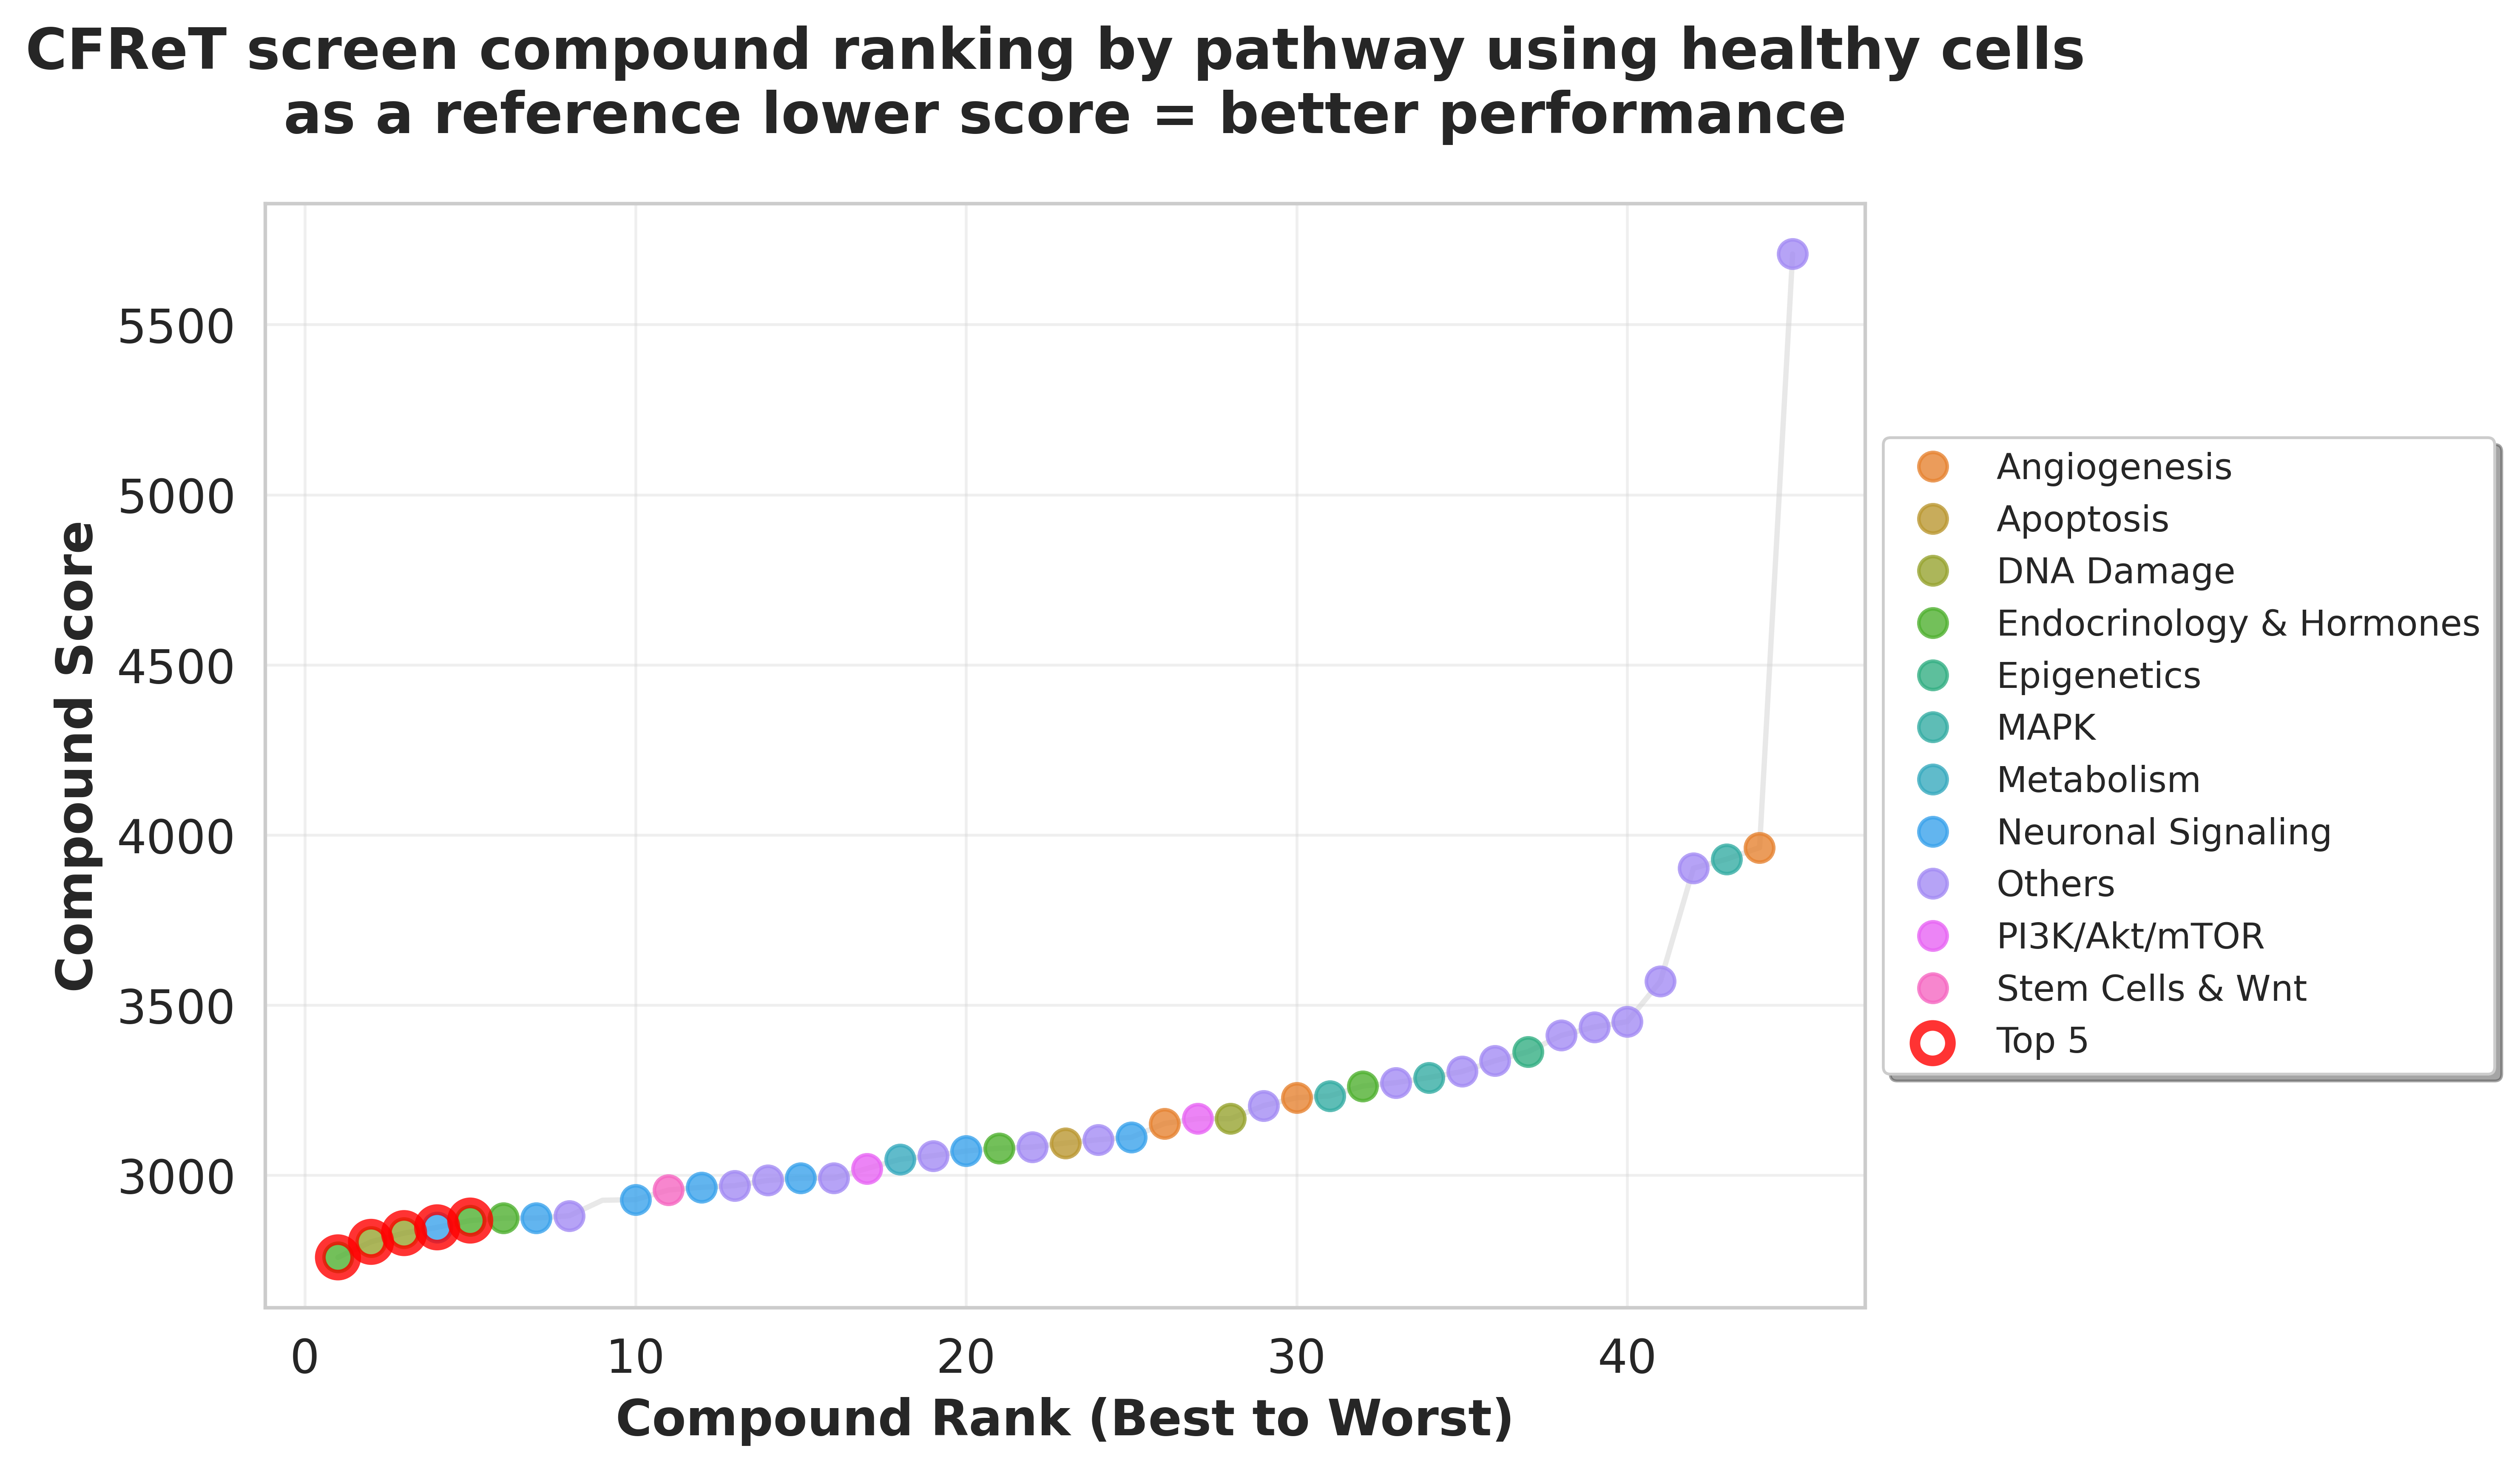

In [18]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=600)
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)

# Get unique pathways and create color palette
ranks_df = ranks_df.sort("rank")
unique_pathways = ranks_df["Pathway"].unique().sort()
palette = sns.color_palette("husl", len(unique_pathways))
pathway_colors = dict(zip(unique_pathways, palette))

# Create rank plot colored by pathway
for pathway in unique_pathways:
    pathway_data = ranks_df.filter(pl.col("Pathway") == pathway)
    ax.plot(
        pathway_data["rank"],
        pathway_data["compound_score"],
        linewidth=0,
        marker="o",
        markersize=8,
        color=pathway_colors[pathway],
        alpha=0.8,
        label=pathway,
    )

# Add connecting line
ax.plot(
    ranks_df["rank"],
    ranks_df["compound_score"],
    linewidth=1.5,
    color="lightgray",
    alpha=0.5,
    zorder=1,
)

# Highlight top 5 compounds
top_5 = ranks_df.head(5)
ax.scatter(
    top_5["rank"],
    top_5["compound_score"],
    s=100,
    zorder=5,
    alpha=0.8,
    edgecolors="red",
    facecolors="none",
    linewidth=3,
    label="Top 5",
)

# Labels and title
ax.set_xlabel("Compound Rank (Best to Worst)", fontsize=14, fontweight="bold")
ax.set_ylabel("Compound Score", fontsize=14, fontweight="bold")
ax.set_title(
    "CFReT screen compound ranking by pathway using healthy cells \nas a reference lower score = better performance",
    fontsize=16,
    fontweight="bold",
    pad=20,
)

# Legend
ax.legend(
    loc="center left", bbox_to_anchor=(1, 0.5), frameon=True, shadow=True, fontsize=10
)

# Grid
ax.grid(True, alpha=0.3)

# Tight layout and save
plt.tight_layout()
fig_path = pathlib.Path(
    "./results/cfret-screen/compound_ranking_plot_by_pathway.png"
).resolve()
plt.savefig(fig_path, dpi=600, bbox_inches="tight")
plt.savefig(fig_path.with_suffix(".pdf"), bbox_inches="tight")
plt.show()